## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams.

Fair warning: Some of these scam e-mails have offensive content. If you start reading the e-mail text or the token data, you might read something offensive. If that's a problem, feel free to e-mail me, and we can talk about it and discuss how to proceed with alternative tasks.

### Q1.

**Tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [28]:
import pickle
with open('/content/all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens.

What do you notice about the frequency of occurrence of different tokens? How does it look?

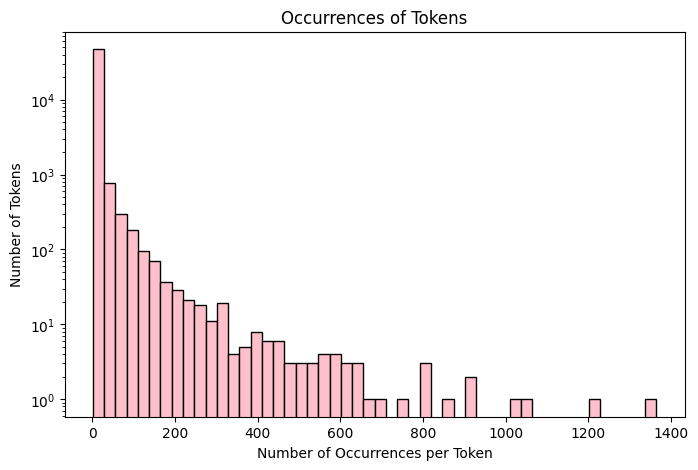

In [36]:
import matplotlib.pyplot as plt

# Get the frequencies of all tokens
counts = [count for word, count in token_freq]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(counts, bins=50, color='pink', edgecolor='black')
plt.title('Occurrences of Tokens')
plt.xlabel('Number of Occurrences per Token')
plt.ylabel('Number of Tokens')
plt.yscale('log')
plt.show()

The histogram shows that most tokens occur only a few times, while a small number appear very frequently. This creates a long-tailed distribution typical of natural language, where common words dominate but many rare words appear infrequently. Such variation reflects the diverse vocabulary used across the emails.

### Q2.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np

# 1. Load data
df = pd.read_parquet('/content/Phishing_clean.parquet')

# 2. Split data
X = df.drop(columns=['Email Type'])
y = df['Email Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Fit linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Compute R²
r2_train = model.score(X_train, y_train)
r2_test = model.score(X_test, y_test)

print("R² on training set:", round(r2_train, 3))
print("R² on test set:", round(r2_test, 3))

# 5. Identify words with largest coefficients
coefs = pd.Series(model.coef_, index=X.columns)
top_words = coefs.abs().sort_values(ascending=False).head(10)
print("\nTop 10 words by absolute coefficient:")
print(top_words)

R² on training set: 0.767
R² on test set: 0.666

Top 10 words by absolute coefficient:
intervention         1.259257
localized            0.824350
thermal              0.747006
crawler              0.696167
background-image:    0.622909
helvetica,           0.598560
aging                0.594956
form.                0.576886
gray;                0.574480
a:active             0.574480
dtype: float64


After an 80/20 train-test split, the regression model produced an R-squared of 0.77 on the training set and 0.67 on the test set. Words like “intervention,” “localized,” and “thermal” had the largest coefficients, meaning they most strongly influenced whether an email was classified as a scam. Overall, the model does a good job finding patterns in the words used across different emails.

### Q3.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

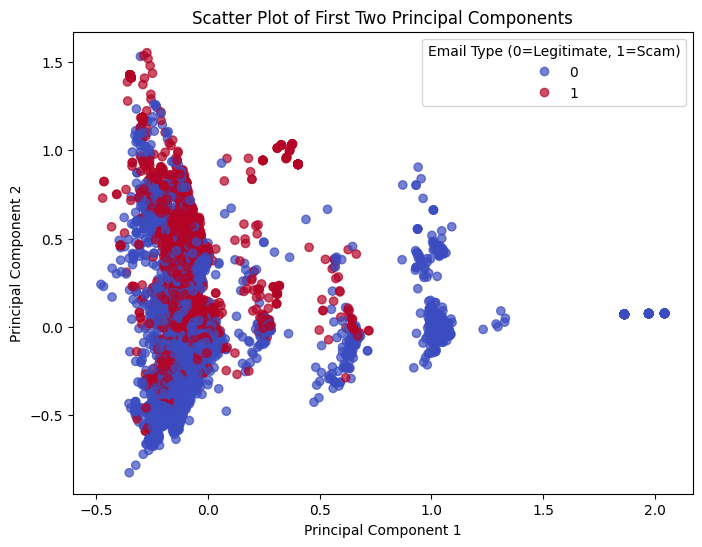

In [37]:
from sklearn.decomposition import PCA

def demean(x):
    xbar = np.mean(x)
    z = x - xbar
    return(z)

X_demeaned = X.apply(demean)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_demeaned)
pca_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "Email Type": y
})

plt.figure(figsize=(8,6))
scatter = plt.scatter(pca_df["PC1"], pca_df["PC2"],
                      c=pca_df["Email Type"], cmap="coolwarm", alpha=0.7)
plt.title("Scatter Plot of First Two Principal Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(*scatter.legend_elements(), title="Email Type (0=Legitimate, 1=Scam)")
plt.show()


The scatter plot of the first two principal components shows that scam emails (red) cluster more tightly, suggesting they share similar patterns in word usage and structure. Legitimate emails (blue) are more spread out, reflecting greater diversity in language and content. Although there is some overlap, PCA captures clear differences between the two types of emails based on their word distributions.

### Q4.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [35]:
from sklearn.linear_model import LinearRegression

#Split data
X = df.drop(columns=['Email Type'])
y = df['Email Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Run PCA with 2,610 components
pca = PCA(n_components=2610, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

#Fit linear regression
model_pca = LinearRegression()
model_pca.fit(X_train_pca, y_train)

#Evaluate performance
r2_train_pca = model_pca.score(X_train_pca, y_train)
r2_test_pca = model_pca.score(X_test_pca, y_test)

print("R² on training set (PCA):", round(r2_train_pca, 3))
print("R² on test set (PCA):", round(r2_test_pca, 3))


R² on training set (PCA): 0.766
R² on test set (PCA): 0.668


After running a linear regression on the first 2,610 principal components, the model had an R-squared of 0.766 on the training set and 0.668 on the test set. This is almost the same as the results from the regression using all one-hot-encoded features. It shows that PCA keeps most of the important information while reducing the number of variables in the model, meaning we can achieve nearly the same predictive power with fewer dimensions.

### Q5.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

Using principal components makes the regression more efficient and stable. Instead of working with thousands of highly correlated word columns, PCA turns them into a smaller set of uncorrelated features that still capture most of the variation in the data. This reduces noise and multicollinearity, making the model easier to interpret and less likely to overfit.